CODE BLOCK: 1

In [1]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

In [3]:
from utils import get_device, print_cuda_info

CODE BLOCK: 2

In [4]:
print_cuda_info()

CUDA Available? True


CODE BLOCK: 3

In [5]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [6]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=train_transforms)

CODE BLOCK: 5

In [7]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

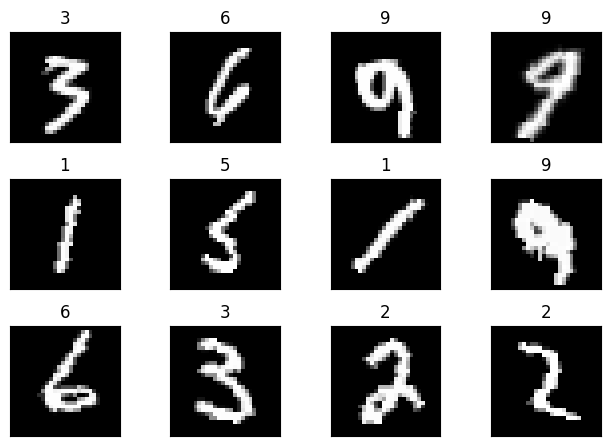

In [8]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [9]:
from models.model_3 import Net

In [10]:
# del Net

In [11]:
from utils import get_device
device = get_device()

In [12]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,168
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 24, 22, 22]           3,480
              ReLU-8           [-1, 24, 22, 22]               0
       BatchNorm2d-9           [-1, 24, 22, 22]              48
        MaxPool2d-10           [-1, 24, 11, 11]               0
           Conv2d-11             [-1, 10, 9, 9]           2,170
             ReLU-12             [-1, 10, 9, 9]               0
      BatchNorm2d-13             [-1, 10, 9, 9]              20
AdaptiveAvgPool2d-14             [-1, 1

/content/models/model_3.py:55: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


CODE BLOCK: 8

In [13]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [14]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()


    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [15]:
device = torch.cuda.current_device()
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.1921 Batch_id=117 Accuracy=82.60: 100%|██████████| 118/118 [00:33<00:00,  3.53it/s]


Test set: Average loss: 0.1867, Accuracy: 9537/10000 (95.37%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.0637 Batch_id=117 Accuracy=95.96: 100%|██████████| 118/118 [00:22<00:00,  5.24it/s]


Test set: Average loss: 0.1175, Accuracy: 9671/10000 (96.71%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0916 Batch_id=117 Accuracy=96.99: 100%|██████████| 118/118 [00:22<00:00,  5.26it/s]


Test set: Average loss: 0.0932, Accuracy: 9726/10000 (97.26%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0660 Batch_id=117 Accuracy=97.33: 100%|██████████| 118/118 [00:23<00:00,  5.01it/s]


Test set: Average loss: 0.0885, Accuracy: 9737/10000 (97.37%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0291 Batch_id=117 Accuracy=97.53: 100%|██████████| 118/118 [00:22<00:00,  5.27it/s]


Test set: Average loss: 0.0737, Accuracy: 9777/10000 (97.77%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0941 Batch_id=117 Accuracy=97.77: 100%|██████████| 118/118 [00:22<00:00,  5.29it/s]


Test set: Average loss: 0.0657, Accuracy: 9788/10000 (97.88%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0829 Batch_id=117 Accuracy=97.88: 100%|██████████| 118/118 [00:23<00:00,  5.11it/s]


Test set: Average loss: 0.0606, Accuracy: 9827/10000 (98.27%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.1174 Batch_id=117 Accuracy=98.01: 100%|██████████| 118/118 [00:22<00:00,  5.24it/s]


Test set: Average loss: 0.0608, Accuracy: 9812/10000 (98.12%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0676 Batch_id=117 Accuracy=98.10: 100%|██████████| 118/118 [00:23<00:00,  5.02it/s]


Test set: Average loss: 0.0576, Accuracy: 9823/10000 (98.23%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0402 Batch_id=117 Accuracy=98.09: 100%|██████████| 118/118 [00:22<00:00,  5.19it/s]


Test set: Average loss: 0.0520, Accuracy: 9844/10000 (98.44%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 11


Train: Loss=0.0234 Batch_id=117 Accuracy=98.38: 100%|██████████| 118/118 [00:22<00:00,  5.27it/s]


Test set: Average loss: 0.0485, Accuracy: 9848/10000 (98.48%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 12


Train: Loss=0.0559 Batch_id=117 Accuracy=98.40: 100%|██████████| 118/118 [00:22<00:00,  5.13it/s]


Test set: Average loss: 0.0509, Accuracy: 9846/10000 (98.46%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 13


Train: Loss=0.0296 Batch_id=117 Accuracy=98.34: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


Test set: Average loss: 0.0490, Accuracy: 9839/10000 (98.39%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 14


Train: Loss=0.0178 Batch_id=117 Accuracy=98.36: 100%|██████████| 118/118 [00:22<00:00,  5.19it/s]


Test set: Average loss: 0.0493, Accuracy: 9845/10000 (98.45%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 15


Train: Loss=0.0147 Batch_id=117 Accuracy=98.40: 100%|██████████| 118/118 [00:22<00:00,  5.14it/s]


Test set: Average loss: 0.0497, Accuracy: 9846/10000 (98.46%)

Adjusting learning rate of group 0 to 1.0000e-03.


CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

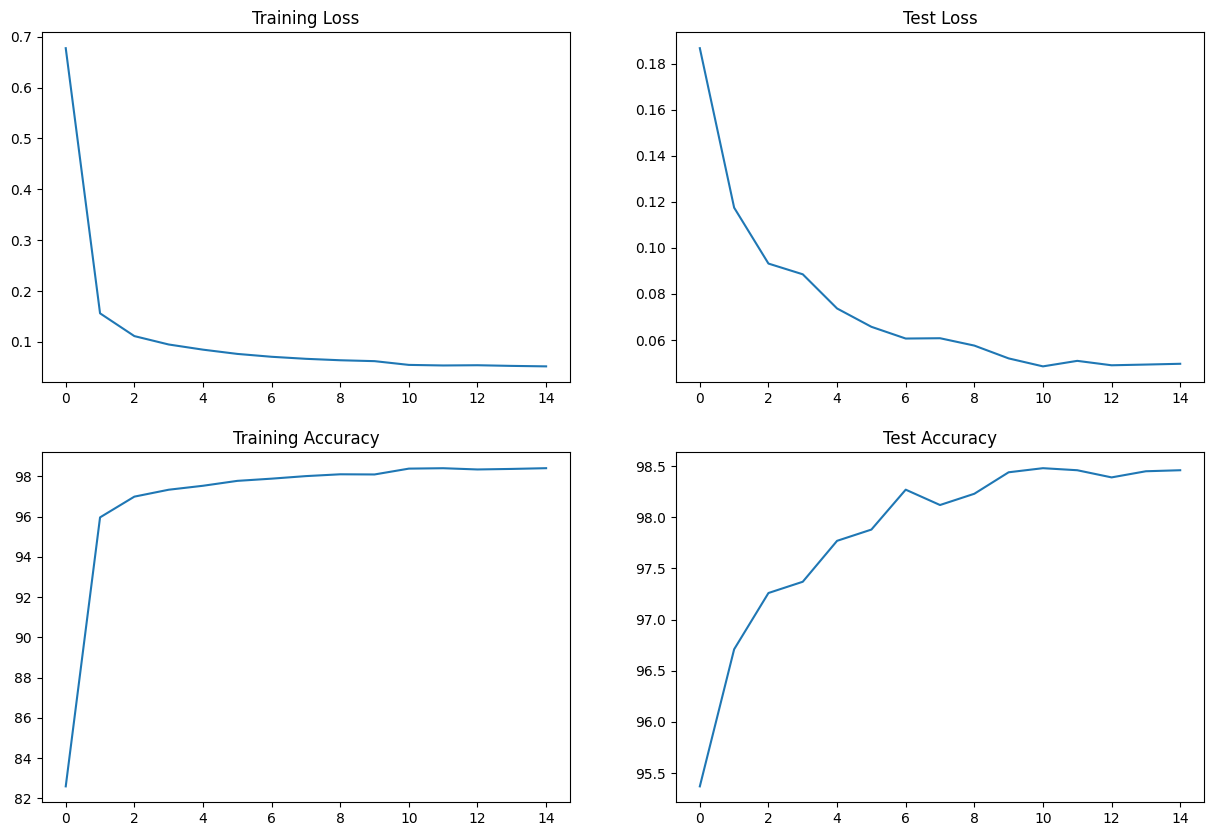

In [16]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")